In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
import matplotlib.ticker as ticker
from tqdm import tqdm
from numba import njit
np.random.seed(0)

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

In [129]:
### 1.1 
n, m = 10, 20 # dimension of the grid
T = 10 # time steps

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited = 1
refractor = 2

# initial state
s0 = np.random.randint(0, 3, [n, m]) 
s = s0.copy()
results = np.empty([T, *s.shape])

@njit
def excite(s0, excited=excited): # rest -> excited according to some condition
    s = s0.copy()
    for i in range(1, n-1):
        for j in range(1, m-1):
            # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
            # This occurs for the previous state
            neighborhood = np.array([
                s0[i-1, j], s0[i, j-1], s0[i, j+1], s0[i+1, j]
            ])
            
            # Checks if there is at least one excited state in the neighbor. 
            if np.sum(neighborhood == excited) >= 1:
                # If yes, excite the cell (give it value 1). 
                s[i, j] = excited
    return s

### 1.2
# Loop for time evolution of the system
for t in tqdm(range(T)):
    results[t] = s0
    # unconditional transition
    s[s0 == excited] = refractor # excited -> refractor
    s[s0 == refractor] = rest # refractor -> rest
    # excitation with some condition
    s = excite(s0) 
    s0 = s # s0 is now the evolved state

100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


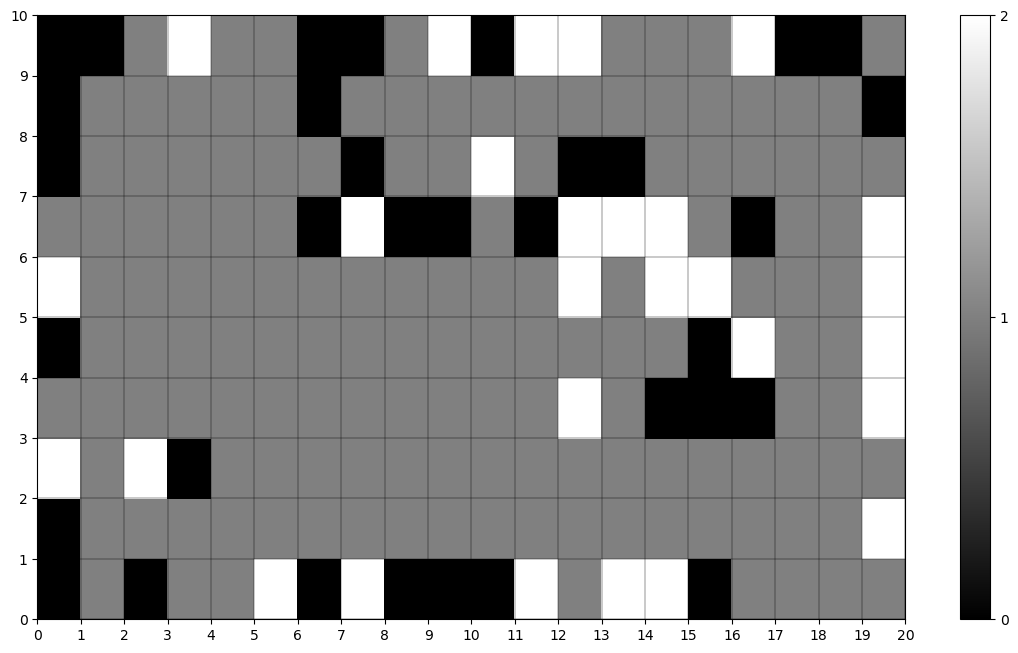

In [164]:
plt.pcolormesh(results[1], vmin=0, vmax=2)  
plt.colorbar(ticks=range(3))
plt.xticks(range(m+1)), plt.yticks(range(n+1))
plt.grid(lw=(n+m)/100, color="k")
plt.show()

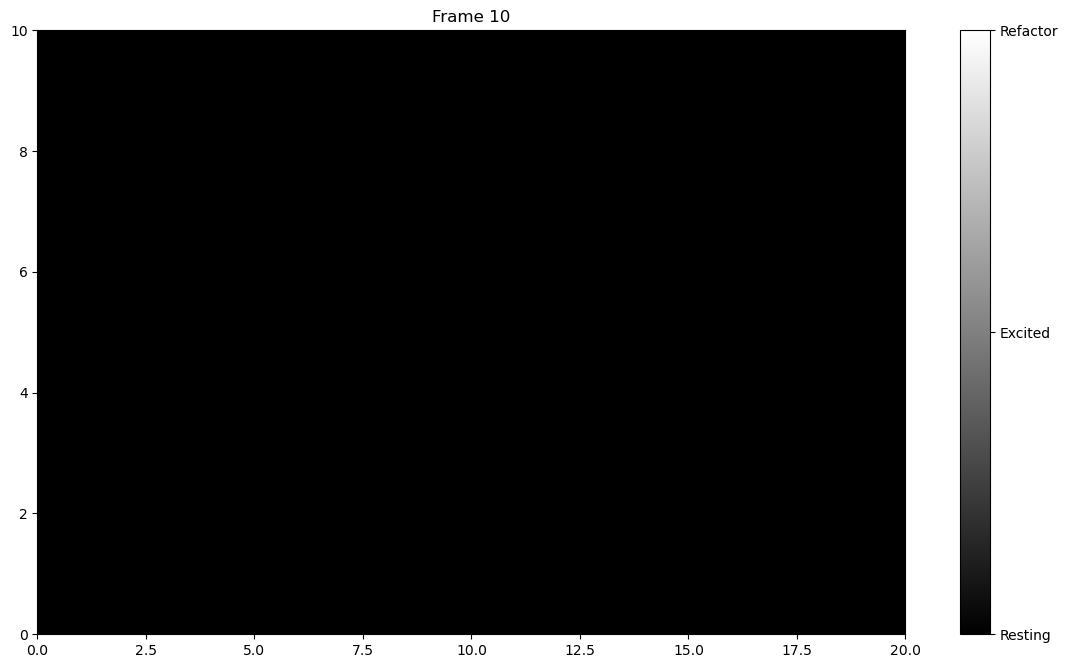

In [162]:
def update_plot(i, im, results):
    im.set_array(results[i])
    plt.title('Frame {}'.format(i+1))
    return [im]

def state_formatter(x, pos):
    states = ["Resting", "Excited", "Refactor"]
    return states[int(x)]

def create_gif(results, filename, duration=100):
    fig = plt.figure()
    im = plt.pcolormesh(results[-1], animated=True, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(state_formatter))

    ani = FuncAnimation(fig, update_plot, frames=range(T), 
                        fargs=(im, results), interval=duration, blit=True)
    ani.save(filename, writer='pillow', fps=1)

create_gif(results, 'GHCA.gif', duration=100)